In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Layer, MultiHeadAttention
from tensorflow.keras.layers import Bidirectional, Dropout
from tensorflow.keras.layers import Masking, Input, Lambda
import tensorflow_probability as tfp
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse
from numpy.fft import fft
from scipy.stats import skew, kurtosis 
import pandas as pd
import glob
import matplotlib.pyplot as plt
import os
import struct
import glob
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, accuracy_score

# Custom loss function
def custom_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    y_pred_clipped = tf.clip_by_value(y_pred, 1e-9, 1.0)  # Clip values to avoid log(0)
    entropy_reg = -tf.reduce_mean(y_pred_clipped * tf.math.log(y_pred_clipped))
    lambda_entropy = 0.01
    return mse + lambda_entropy * entropy_reg

def count_lines(filepath):
    with open(filepath, 'rb') as f:
        return sum(1 for _ in f)

def load_data(filepath):
    _, file_extension = os.path.splitext(filepath)
    
    if file_extension == '.csv':
        df = pd.read_csv(filepath)
        samples = df['your_column_name'].values
    elif file_extension == '.dat':
        #Looks like DAT is binary encoded added a b in r as rb
        with open(filepath, 'rb') as f:
            samples = f.readlines()
        samples = np.array([sample.strip() for sample in samples])
    else:
        raise ValueError(f"Unsupported file format: {file_extension}")
    
    return samples

def count_lines(filepath):
    with open(filepath, 'rb') as f:
        return sum(1 for _ in f)

class DataGenerator:        
    def __init__(self, filepath, batch_size, sequence_length, max_samples=None, for_training=True):
        self.filepath = filepath
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.max_samples = max_samples
        self.for_training = for_training
        self.samples = []
        self.binary_file = open(self.filepath, 'rb')  # Initialize the binary_file here
        self.reset()

    def reset(self):
        self.total_samples_processed = 0
        _, self.file_extension = os.path.splitext(self.filepath)
        print(f"File extension detected: {self.file_extension}")  # Add this line


    def __iter__(self):
        self.binary_file.seek(0)  # reset file pointer
        self.samples = []
        return self
    
    def close(self):
        if not self.binary_file.closed:
            self.binary_file.close()

    def process_data1(self, samples):
        real_parts = []
        imag_parts = []
        for sample in samples:
            try:
                cnum = complex(sample.replace('j', 'j'))
                real_parts.append(np.real(cnum))
                imag_parts.append(np.imag(cnum))
            except ValueError:
                continue

        real_parts = (real_parts - np.mean(real_parts)) / np.std(real_parts)
        imag_parts = (imag_parts - np.mean(imag_parts)) / np.std(imag_parts)

        X = [list(zip(real_parts[i:i+self.sequence_length], imag_parts[i:i+self.sequence_length])) for i in range(len(real_parts) - self.sequence_length)]
        return np.array(X)
    def process_data2(self, samples):
        # Convert samples list to a NumPy array and check the total number of samples
        samples_array = np.array(samples, dtype=np.complex64)
        total_samples = samples_array.size

        # Ensure that the total number of samples matches self.batch_size * self.sequence_length
        if total_samples != self.batch_size * self.sequence_length:
            # Handle this scenario: you might want to raise an error or handle it in some way
            raise ValueError("Total number of samples does not match batch_size * sequence_length")

        # Check for invalid values in samples_array before processing
        if np.isnan(samples_array).any() or np.isinf(samples_array).any():
            print(f"Invalid values found in samples_array: {samples_array}")
        # Reshape the samples array
        samples_array = samples_array.reshape(self.batch_size, self.sequence_length)
        print('samples_array.shape:', samples_array.shape)

        # Apply FFT to convert time-domain signals into frequency domain
        samples_fft = fft(samples_array)
        print('samples_fft.shape:', samples_fft.shape)

        # Extract real and imaginary parts
        real_parts = np.real(samples_fft)
        imag_parts = np.imag(samples_fft)

#         # Normalize the real and imaginary parts
#         real_parts = (real_parts - np.mean(real_parts, axis=1, keepdims=True)) / np.std(real_parts, axis=1, keepdims=True)
#         imag_parts = (imag_parts - np.mean(imag_parts, axis=1, keepdims=True)) / np.std(imag_parts, axis=1, keepdims=True)
        
        # Normalize the real and imaginary parts
        epsilon = 1e-10
        real_parts_mean = np.mean(real_parts, axis=1, keepdims=True)
        real_parts_std = np.std(real_parts, axis=1, keepdims=True)
        real_parts_std[real_parts_std == 0] = epsilon  # Avoid division by zero
        real_parts = (real_parts - real_parts_mean) / real_parts_std

        imag_parts_mean = np.mean(imag_parts, axis=1, keepdims=True)
        imag_parts_std = np.std(imag_parts, axis=1, keepdims=True)
        imag_parts_std[imag_parts_std == 0] = epsilon  # Avoid division by zero
        imag_parts = (imag_parts - imag_parts_mean) / imag_parts_std

        # Extract statistical features from the real and imaginary parts
        features = np.column_stack((
            np.mean(real_parts, axis=1),
            np.std(real_parts, axis=1),
            skew(real_parts, axis=1),
            kurtosis(real_parts, axis=1),
            np.mean(imag_parts, axis=1),
            np.std(imag_parts, axis=1),
            skew(imag_parts, axis=1),
            kurtosis(imag_parts, axis=1)
        ))

        # Reshape features to match the input shape of the model
        X = features.reshape(-1, self.sequence_length, features.shape[1])
        return X

    def __next__(self):
        chunksize = self.batch_size * self.sequence_length
        global totalMagnitude  # Access the global variable
        global totalnumberofsamples  # Access the global variable
        
        #if self.file_extension == '.dat':        
        samples = []
        while True:
            binary_data = self.binary_file.read(8)
            if not binary_data:
                break  # End of file
            decoded_data = struct.unpack('ff', binary_data)
            
            # Skip samples that are exactly zero (0 + 0j)
            if decoded_data[0] == 0 and decoded_data[1] == 0:
                continue

            # Convert the binary data to a complex number string
            decoded_line = f"{decoded_data[0]}+{decoded_data[1]}j\n" if decoded_data[1] >= 0 else f"{decoded_data[0]}{decoded_data[1]}j\n"
            samples.append(decoded_line)

            # Check if we have enough samples for a batch
            if len(samples) == chunksize:
                X_chunk = self.process_data1(samples)
                if self.for_training:
                    return X_chunk, X_chunk
                else:
                    return X_chunk
                # Clear samples for the next batch (optional, depends on your logic)
                samples = []
#------------------------------------------------------------------------------------------------------
# Minimum Entropy Coupling (MEC) Functions
def mec_kocaoglu_np(p, q):
    """
    Compute the joint distribution matrix with minimal entropy between two given distributions.
    """
    p = tf.cast(p, tf.float64) / tf.reduce_sum(p)
    q = tf.cast(q, tf.float64) / tf.reduce_sum(q)
    J = tf.zeros((tf.size(q), tf.size(p)), dtype=tf.float64)
    M = tf.stack([p, q], axis=0)
    r = tf.reduce_min(tf.reduce_max(M, axis=1))
    #print('Input shapes to mec_kocaoglu_np:', p.shape, q.shape)

    def body(r, M, J):
        a_i = tf.argmax(M, axis=1)
        r_updated = tf.reduce_min(tf.reduce_max(M, axis=1))
        update_values = tf.stack([r, r])

        # Ensure tensors have the same data type before stacking
        a_i = tf.cast(a_i, dtype=tf.int32)  # Cast to int32 (or choose another common dtype)
        indices_range = tf.range(tf.size(a_i), dtype=tf.int32)  # Ensure range has the same dtype

        # Prepare indices for scatter update
        indices = tf.stack([indices_range, a_i], axis=1)

        # Update M
        M_updates = tf.scatter_nd(indices, -update_values, tf.shape(M))
        M = M + M_updates

        # Update J
        J_updates = tf.scatter_nd(indices, [r, r], tf.shape(J))
        J = J + J_updates

        return r_updated, M, J

    def condition(r, M, J):
        return r > 0

    r, M, J = tf.while_loop(condition, body, loop_vars=[r, M, J])

    return J
def simplified_mec_kocaoglu_np(p, q):
    """
    Simplify the computation of the MEC transformation by directly averaging
    the two distributions, p and q, to reduce complexity and variability.
    """
    # Ensure p and q are normalized to the same sum
    p_normalized = tf.cast(p, tf.float64) / tf.reduce_sum(p)
    q_normalized = tf.cast(q, tf.float64) / tf.reduce_sum(q)

    # Compute a simple average of the two distributions
    averaged_distribution = (p_normalized + q_normalized) / 2

    # Optionally, could apply a fixed transformation based on the averaged distribution
    # here applied a threshold to limit the range of possible outcomes
    fixed_threshold = 0.5  # Example fixed parameter
    transformed_distribution = tf.where(averaged_distribution > fixed_threshold,
                                        averaged_distribution,
                                        tf.zeros_like(averaged_distribution))

    return transformed_distribution
def central_tendency_mec_kocaoglu_np(p, q):
    """
    Further simplify the MEC transformation by focusing on the central tendency
    of the distributions p and q, to reduce complexity and variability.
    This version uses the median as a robust measure of central tendency.
    """
    # Ensure p and q are normalized to the same sum
    p_normalized = tf.cast(p, tf.float64) / tf.reduce_sum(p)
    q_normalized = tf.cast(q, tf.float64) / tf.reduce_sum(q)
    
    # Use median as a robust measure of central tendency
    p_median = tfp.stats.percentile(p_normalized, 50.0)
    q_median = tfp.stats.percentile(q_normalized, 50.0)
    
    # Compute a simple average of the two medians
    averaged_median = (p_median + q_median) / 2
    
    # Optionally, apply a fixed threshold to further simplify the transformation
    # For example, this could be used to create a binary feature
    simplified_feature = tf.cast(averaged_median > 0.5, tf.float64)
    
    # Generate a constant distribution based on the simplified feature
    # This constant distribution significantly reduces variations
    constant_distribution = tf.fill(tf.shape(p_normalized), simplified_feature)
    
    return constant_distribution
def minimal_variation_mec_transformation(p, q, global_median_threshold=0.5):
    """
    Apply a minimal variation MEC transformation to each sample based on a global median threshold.
    This version categorizes the median of the distribution in relation to a fixed global threshold,
    applying a minimal and highly predictable adjustment.
    """
    # Normalize distributions to have the same sum
    p_normalized = tf.cast(p, tf.float64) / tf.reduce_sum(p)
    q_normalized = tf.cast(q, tf.float64) / tf.reduce_sum(q)
    
    # Calculate the median of normalized distributions
    p_median = tfp.stats.percentile(p_normalized, 50.0)
    q_median = tfp.stats.percentile(q_normalized, 50.0)
    
    # Determine the category based on the global median threshold
    p_category = tf.cast(p_median > global_median_threshold, tf.float64)
    q_category = tf.cast(q_median > global_median_threshold, tf.float64)
    
    # Compute a simple average of the categories
    averaged_category = (p_category + q_category) / 2
    
    # Generate a constant distribution based on the averaged category
    # This results in minimal variation as it's based on a static, global threshold
    constant_distribution = tf.fill(tf.shape(p_normalized), averaged_category)
    
    return constant_distribution


def apply_mec_to_data(data, num_bins=100, latent_dim=25):
    """
    Apply the MEC transformation to each sample in the data using tf.map_fn.
    """
    def process_sample(sample):
        #print("Original sample shape:", sample.shape)

        min_val = tf.reduce_min(sample)
        max_val = tf.reduce_max(sample)
        sample_distribution = tf.histogram_fixed_width(sample, [min_val, max_val], nbins=num_bins)
        sample_distribution = tf.cast(sample_distribution, tf.float64)
        sum_distribution = tf.cast(tf.reduce_sum(sample_distribution), tf.float64)
        sample_distribution /= sum_distribution

        #print("Sample distribution shape:", sample_distribution.shape)

        mec_transformed = mec_kocaoglu_np(sample_distribution, sample_distribution)
        #print("MEC transformed shape (initial):", mec_transformed.shape)

        # Flatten the 2D tensor to 1D if necessary
        if len(mec_transformed.shape) > 1:
            transformed_sample = tf.reshape(mec_transformed, [-1])
            #print("Flattened MEC transformed shape:", transformed_sample.shape)

        # Slice or pad the tensor to match the latent_dim
        if transformed_sample.shape[0] > latent_dim:
            transformed_sample = transformed_sample[:latent_dim]
        elif transformed_sample.shape[0] < latent_dim:
            padding = tf.zeros(latent_dim - transformed_sample.shape[0], dtype=tf.float64)
            transformed_sample = tf.concat([transformed_sample, padding], axis=0)

        #print("Transformed sample shape (before reshape):", transformed_sample.shape)

        return tf.reshape(transformed_sample, (latent_dim,))


    # Apply the function to each sample in the batch
    transformed_batch = tf.map_fn(process_sample, data, dtype=tf.float64, parallel_iterations=10)

    return transformed_batch
def apply_mec_to_data_simple(data, latent_dim=25):
    """
    Apply a simplified MEC transformation to each sample in the data.
    This version aims to apply the MEC transformation with minimal changes to the data.
    """

    def process_sample(sample):
        print("Original sample shape:", sample.shape)  # Diagnostic print
        
        # Cast the sample to tf.float64 for dtype consistency
        sample = tf.cast(sample, tf.float64)
        sample_normalized = sample / tf.reduce_sum(sample, keepdims=True)
        
        # Diagnostic print for normalized sample shape
        print("Normalized sample shape:", sample_normalized.shape)
        
        # Apply MEC transformation
        #mec_transformed = mec_kocaoglu_np(sample_normalized, sample_normalized)
        #mec_transformed = simplified_mec_kocaoglu_np(sample_normalized, sample_normalized)
        mec_transformed = central_tendency_mec_kocaoglu_np(sample_normalized, sample_normalized)
        
        # Diagnostic print for MEC-transformed tensor shape
        print("MEC-transformed tensor shape:", mec_transformed.shape)
        
        # Flatten the MEC-transformed tensor to 1D for simplicity
        mec_transformed_flat = tf.reshape(mec_transformed, [-1])
        
        # Diagnostic print for flattened MEC-transformed tensor shape
        print("Flattened MEC-transformed tensor shape:", mec_transformed_flat.shape)
        
        # Calculate padding size
        padding_size = tf.maximum(tf.cast(0, tf.int64), latent_dim - tf.cast(tf.size(mec_transformed_flat), tf.int64))
        
        # Apply padding
        padded_mec_transformed = tf.pad(mec_transformed_flat, paddings=[[0, padding_size]], constant_values=0.0)
        
        # Diagnostic print for padded MEC-transformed tensor shape
        print("Padded MEC-transformed tensor shape:", padded_mec_transformed.shape)
        
        # Ensure the tensor matches exactly the latent_dim
        final_transformed = padded_mec_transformed[:latent_dim]
        
        # Diagnostic print for final transformed tensor shape
        print("Final transformed tensor shape:", final_transformed.shape)

        return final_transformed

    # Apply the process to each sample and return the transformed data
    transformed_data = tf.map_fn(process_sample, data, dtype=tf.float64, parallel_iterations=10)

    print("Transformed data shape:", transformed_data.shape)  # Diagnostic print at the end

    return transformed_data

def apply_minimal_variation_mec(data, latent_dim=25, global_median_threshold=0.5):
    """
    Apply a minimal variation MEC transformation to each sample in the data.
    """

    def process_sample(sample):
        sample = tf.cast(sample, tf.float64)
        # Apply the minimal variation MEC transformation
        mec_transformed = minimal_variation_mec_transformation(sample, sample, global_median_threshold)
        
        # Ensure the transformed tensor matches the latent dimension size
        final_transformed = tf.reshape(mec_transformed, [latent_dim])
        
        return final_transformed

    # Apply the process to each sample and return the transformed data
    transformed_data = tf.map_fn(process_sample, data, dtype=tf.float64, parallel_iterations=10)

    return transformed_data

#     def process_sample(sample):
#         # Normalize the sample distribution
#         sample = tf.cast(sample, tf.float64) / tf.reduce_sum(sample)
        
#         # mec_kocaoglu_np expects two distributions, so we pass the sample as both p and q.
#         # This is a simplification strategy and might not fully leverage the capabilities of MEC.
#         mec_transformed = mec_kocaoglu_np(sample, sample)

#         # Flatten the transformed matrix to a vector by summing over one axis.
#         mec_transformed = tf.reduce_sum(mec_transformed, axis=0)

#     #def process_sample(sample):
#         #mec_transformed = mec_kocaoglu_np(sample)

#         # Ensure the transformed sample matches the desired latent dimension size.
#         # This simply pads or slices the transformed data without additional processing.
#         padding_size = max(0, latent_dim - tf.size(mec_transformed))
#         mec_transformed = tf.pad(mec_transformed, [[0, padding_size]], constant_values=0)
#         mec_transformed = tf.slice(mec_transformed, [0], [latent_dim])

#         return mec_transformed

    # Apply the simplified MEC process to each sample.
#     transformed_data = tf.map_fn(process_sample, data, dtype=tf.float32, parallel_iterations=10)

#     return transformed_data

def process_latent_variables(z):
    """
    Process the latent variables with MEC transformation.
    """
    # Apply MEC transformation to the latent variables
    #print('Input to process_latent_variables shape:', z.shape)
    #z_transformed = apply_mec_to_data(z)
    #z_transformed = apply_mec_to_data_simple(z)
    z_transformed = apply_minimal_variation_mec(z)
    #print('Output of MEC transformation shape:', z_transformed.shape)
    return z_transformed

#self Attention LSTM Autoencoder Model
class SelfAttentionLayer(Layer):
    def __init__(self, num_heads, key_dim):
        super(SelfAttentionLayer, self).__init__()
        self.multi_head_attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

    def call(self, inputs):
        return self.multi_head_attention(inputs, inputs, inputs)

# Variational Autoencoder (VAE) Class
class VAE:
    def __init__(self, sequence_length, feature_dim, original_dim, intermediate_dim, latent_dim,
                 epsilon_std=0.1, dropout_rate=0.2):
        self.sequence_length = sequence_length
        self.feature_dim = feature_dim
        self.original_dim = original_dim
        self.intermediate_dim = intermediate_dim
        self.latent_dim = latent_dim
        self.epsilon_std = epsilon_std
        self.dropout_rate = dropout_rate
        self.encoder = None
        self.decoder = None
        self.vae = None
        #self._build()
        self._build2()


    def _sampling3(self, args):
        z_mean, _ = args  # Ignore z_log_var for simplicity
        epsilon_std = 0.1  # Use a fixed small std deviation to reduce variability
        epsilon = K.random_normal(shape=K.shape(z_mean), mean=0., stddev=epsilon_std)
        return z_mean + epsilon
    def _sampling(self, args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=self.epsilon_std)
        output = z_mean + K.exp(0.5 * z_log_var) * epsilon
        return output
    
    def _sampling4(self, args):
        """
        Sampling function to generate samples from the latent space.
        """
        z_mean, z_log_var = args

        # Process latent variables with MEC transformation
        z_mean_transformed = process_latent_variables(z_mean)
        z_log_var_transformed = process_latent_variables(z_log_var)
        #print('z_mean_transformed shape:', z_mean_transformed.shape)
        #print('z_log_var_transformed shape:', z_log_var_transformed.shape)

        #print('K.shape(z_mean_transformed):', K.shape(z_mean_transformed))
        batch = K.shape(z_mean_transformed)[0]
        #print('batch:', batch)
        dim = K.int_shape(z_mean_transformed)[1]

        # Ensure all tensors have the same data type
        z_mean_transformed = tf.cast(z_mean_transformed, tf.float32)
        z_log_var_transformed = tf.cast(z_log_var_transformed, tf.float32)

        epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=self.epsilon_std)
        output = z_mean_transformed + K.exp(0.5 * z_log_var_transformed) * epsilon
        #print('Sampling output shape:', output.shape)
        return output
    def _sampling5(self, args):
        """
        Sampling function to generate samples from the latent space.
        """
        z_mean, _ = args

        # Process latent variables with MEC transformation
        z_mean_transformed = process_latent_variables(z_mean)
        batch = K.shape(z_mean_transformed)[0]
        #print('batch:', batch)
        dim = K.int_shape(z_mean_transformed)[1]

        # Ensure all tensors have the same data type
        z_mean_transformed = tf.cast(z_mean_transformed, tf.float32)
        #z_log_var_transformed = tf.cast(z_log_var_transformed, tf.float32)

        epsilon_std = 0.1  # Use a fixed small std deviation to reduce variability
        #epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=epsilon_std)
        epsilon = K.random_normal(shape=K.shape(z_mean), mean=0., stddev=epsilon_std)
        return z_mean_transformed + epsilon
        #print('Sampling output shape:', output.shape)
        #return output
        
    def _build(self):
        # Encoder
        inputs = Input(shape=(self.sequence_length, self.feature_dim), name='encoder_input')
        x = LSTM(self.original_dim, activation='relu', return_sequences=True)(inputs)
        x = LSTM(self.intermediate_dim, activation='relu', return_sequences=False)(x)

        # Normally here you would define z_mean and z_log_var and then sample z
        # Instead, for a simple autoencoder, we will use a Dense layer to directly output the latent representation
        latent_repr = Dense(self.latent_dim, name='latent_repr')(x)

        # Skipping the sampling part
        # z = Lambda(self._sampling, output_shape=(self.latent_dim,), name='z')([z_mean, z_log_var])

        # Instantiate the encoder model without z_mean, z_log_var, and z
        self.encoder = Model(inputs, latent_repr, name='encoder')
        
        # Decoder
        latent_inputs = Input(shape=(self.latent_dim,), name='decoder_input')
        x = RepeatVector(self.sequence_length)(latent_inputs)
        x = LSTM(self.intermediate_dim, activation='relu', return_sequences=True)(x)
        x = LSTM(self.original_dim, activation='relu', return_sequences=True)(x)
        outputs = TimeDistributed(Dense(self.feature_dim))(x)

        # Instantiate the decoder model
        self.decoder = Model(latent_inputs, outputs, name='decoder')

        # Autoencoder model
        autoencoder_outputs = self.decoder(self.encoder(inputs))
        self.vae = Model(inputs, autoencoder_outputs, name='simple_autoencoder')

    def _build2(self):
        # Encoder
        #model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 8), 
                       #return_sequences=True)
        inputs = Input(shape=(self.sequence_length, self.feature_dim), name='encoder_input')
        #x = Bidirectional(LSTM(self.intermediate_dim, activation='tanh', return_sequences=True))(inputs)
        x = LSTM(self.original_dim, activation='relu', return_sequences=True)(inputs)
        #x = Dropout(self.dropout_rate)(x)
        #x = LSTM(self.original_dim, activation='relu', return_sequences=True)(x)
        #self_attention = SelfAttentionLayer(num_heads=8, key_dim=self.original_dim)  # Adjust num_heads and key_dim as needed
        #x = self_attention(x)
        #x = Bidirectional(LSTM(self.intermediate_dim, activation='tanh', return_sequences=False))(x)
        x = LSTM(self.intermediate_dim, activation='relu', return_sequences=False)(x)
        #x = Dropout(self.dropout_rate)(x)

        z_mean = Dense(self.latent_dim, name='z_mean')(x)
        z_log_var = Dense(self.latent_dim, name='z_log_var')(x)

        #z = Lambda(self._sampling, output_shape=(self.latent_dim,), name='z')([z_mean, z_log_var])
        # I want to use this simplified sampling method
        #z = Lambda(self._sampling2, output_shape=(self.latent_dim,))([z_mean, z_mean])  # Pass z_mean twice to match expected input structure
        z = Lambda(self._sampling5, output_shape=(self.latent_dim,))([z_mean, z_mean])
        # Instantiate the encoder model
        self.encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
        
        # Decoder
        latent_inputs = Input(shape=(self.latent_dim,), name='z_sampling')
        x = RepeatVector(self.sequence_length)(latent_inputs)
        #x = LSTM(self.intermediate_dim, activation='tanh', return_sequences=True)(x)
        x = LSTM(self.intermediate_dim, activation='relu', return_sequences=True)(x)
        #x = Dropout(self.dropout_rate)(x)
        #x = LSTM(self.original_dim, activation='tanh', return_sequences=True)(x)
        #x = LSTM(self.original_dim, activation='relu', return_sequences=True)(x)
        #x = Dropout(self.dropout_rate)(x)
        x = LSTM(self.original_dim, activation='relu', return_sequences=True)(x)
        #x = Dropout(self.dropout_rate)(x)
        
        # Adjust the final activation based on your data type
        final_activation = 'sigmoid' #'linear' if data is not normalized
        #outputs = TimeDistributed(Dense(self.original_dim, activation=final_activation))(x)
        outputs = TimeDistributed(Dense(self.feature_dim))(x)

        # Instantiate the decoder model
        self.decoder = Model(latent_inputs, outputs, name='decoder')

        # VAE model
        outputs = self.decoder(self.encoder(inputs)[2])
        self.vae = Model(inputs, outputs, name='vae_mlp')

    def vae_loss(self, x, x_decoded_mean, z_mean, z_log_var):
        mse = tf.reduce_mean(tf.square(x - x_decoded_mean), axis=(1, 2))
        xent_loss = mse
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    
    def compile(self, learning_rate=0.001, optimizer='adam'):
        if optimizer == 'adam':
            optimizer = Adam(learning_rate=learning_rate)

        def vae_loss_wrapper(x, x_decoded_mean):
            z_mean, z_log_var, _ = self.encoder(x)
            return self.vae_loss(x, x_decoded_mean, z_mean, z_log_var)

        self.vae.compile(optimizer=optimizer, loss=vae_loss_wrapper)
        
    def custom_loss(self, x, x_decoded_mean, z_mean, z_log_var):
        # Reconstruction Loss
        mse = tf.reduce_mean(tf.square(x - x_decoded_mean), axis=(1, 2))

        # Entropy Regularization
        x_decoded_mean_clipped = tf.clip_by_value(x_decoded_mean, 1e-9, 1.0)  # Clip values to avoid log(0)
        entropy_reg = -tf.reduce_mean(x_decoded_mean_clipped * tf.math.log(x_decoded_mean_clipped), axis=(1, 2))

        # KL Divergence
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

        # Lambda parameters for weighting different components of the loss
        lambda_entropy = 0.01
        lambda_kl = 1.0  # You might want to tune this parameter

        # Combined loss
        total_loss = mse + (lambda_entropy * entropy_reg) + (lambda_kl * kl_loss)
        return K.mean(total_loss)

    def compile2(self, learning_rate=0.0005, optimizer='adam'):
        if optimizer == 'adam':
            optimizer = Adam(learning_rate=learning_rate)

        # Define a wrapper function for the custom loss
        def custom_loss_wrapper(x, x_decoded_mean):
            z_mean, z_log_var, _ = self.encoder(x)
            return self.custom_loss(x, x_decoded_mean, z_mean, z_log_var)

        self.vae.compile(optimizer=optimizer, loss=custom_loss_wrapper)
    def compile_simple_autoencoder(self, learning_rate=0.001, optimizer='adam'):
        if optimizer == 'adam':
            optimizer = Adam(learning_rate=learning_rate)
        
        # Simple reconstruction loss
        self.vae.compile(optimizer=optimizer, loss='mse')
    def compile_with_simplified_sampling(self, learning_rate=0.001, optimizer='adam'):
        if optimizer == 'adam':
            optimizer = Adam(learning_rate=learning_rate)

        # Define a simple reconstruction loss, as the simplified sampling doesn't use z_log_var for variability
        def simplified_loss(x, x_decoded_mean):
            # Reconstruction loss (MSE)
            reconstruction_loss = tf.reduce_mean(tf.square(x - x_decoded_mean), axis=-1)
            # Assuming a fixed variance, the KL divergence could be constant or ignored for simplicity
            # Here, we focus solely on reconstruction loss
            return reconstruction_loss

        self.vae.compile(optimizer=optimizer, loss=simplified_loss)




# Instantiate and Compile the VAE
sequence_length = 10
feature_dim = 2
original_dim = 50
intermediate_dim = 50
latent_dim = 25

vae_model = VAE(sequence_length, feature_dim, original_dim, intermediate_dim, latent_dim)
#vae_model.vae.compile(optimizer='adam', loss=vae_model.vae_loss)
#vae_model.compile2(learning_rate=0.005)
#vae_model.compile_simple_autoencoder(learning_rate=0.005)
vae_model.compile_with_simplified_sampling(learning_rate=0.005)

# Model Training
batch_size = 20
max_train_samples = 2000000
train_steps = max_train_samples // (batch_size * sequence_length)
max_samples = 2000000  # Maximum samples to read (or None to read all)
max_test_samples = 2000000

pure_file_pattern = '/home/mreza/5G accelerator/ID_MEC/data generator/pure_data/pure_iq_samples_*.csv'
mixed_file_pattern = '/home/mreza/5G accelerator/ID_MEC/data generator/mixed_data/mixed_iq_samples_*.csv'
# Example file patterns
#pure_file_pattern = 'C:\\Users\\Mohammadreza\\Desktop\\My Class\\Proj-DC\\My Works\\My Papers\\intrusion\\data generator\\pure_data\\pure_iq_samples_*.csv'
#mixed_file_pattern = 'C:\\Users\\Mohammadreza\\Desktop\\My Class\\Proj-DC\\My Works\\My Papers\\intrusion\\data generator\\mixed_data\\mixed_iq_samples_*.csv'

# Data Generator Instances
# train_gen_instance = CSVDataGenerator(pure_file_pattern, batch_size, sequence_length, 
#                                       max_train_samples, for_training=True)
# combined_gen_instance = CSVDataGenerator(mixed_file_pattern, batch_size, sequence_length, 
#                                          max_test_samples, for_training=False)
train_gen_instance = DataGenerator('/home/mreza/5G accelerator/IQ_samples/data collected/5G_DL_IQ_no_jamming_0924.dat', 
                                   batch_size=batch_size, sequence_length=sequence_length, 
                                   max_samples=max_train_samples, for_training=True)
combined_gen_instance = DataGenerator('/home/mreza/5G accelerator/IQ_samples/data collected/5G_DL_IQ_with_periodic_jamming_0928_02.dat', 
                                      batch_size=batch_size, sequence_length=sequence_length, 
                                      for_training=False)

num_epochs = 4  # You can adjust the number of epochs as needed
steps_per_epoch = train_steps  # Assuming one epoch processes all the data
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_gen_instance.reset()  # Reset the generator at the beginning of each epoch
    for step in range(steps_per_epoch):
        try:
            X_chunk, Y_chunk = next(train_gen_instance)
        except StopIteration:
            train_gen_instance.reset()  # Reset the generator when it runs out of data
            X_chunk, Y_chunk = next(train_gen_instance)

        #loss = model.train_on_batch(X_chunk, Y_chunk)
        loss = vae_model.vae.train_on_batch(X_chunk, Y_chunk)
        #print(f"Step {step + 1}/{steps_per_epoch}", end='\r')
        if step % 100 == 0:
            print(f"Step {step + 1}/{train_steps}, Loss: {loss}")
    print()
    
# for epoch in range(num_epochs):
#     print(f"Epoch {epoch + 1}/{num_epochs}")
#     train_gen_instance.__iter__()  # Reset the generator at the beginning of each epoch

#     for step in range(train_steps):
#         #print('step in train loop:', step)
#         try:
#             #print('Im in try of training loop')
#             X_chunk, Y_chunk = next(train_gen_instance)
#             #print('X_chunk.shape:', X_chunk.shape)
#             #print('Y_chunk.shape:', Y_chunk.shape)
#         except StopIteration:
#             #print('Im in except of training loop')
#             # Reset the generator if needed
#             train_gen_instance.__iter__()
#             X_chunk, Y_chunk = next(train_gen_instance)
#             #print('X_chunk.shape:', X_chunk.shape)
#             #print('Y_chunk.shape:', Y_chunk.shape)

#         #print('inside for step loop just before loss')
#         # Train the VAE model on the batch and get the loss value
#         loss = vae_model.vae.train_on_batch(X_chunk, Y_chunk)

#         # Print the loss every 100 steps
#         if step % 200 == 0:
#             print(f"Step {step + 1}/{train_steps}, Loss: {loss}")

#             # Check for NaN in model predictions
#             pred_sample = vae_model.vae.predict(X_chunk[:1])
#             if np.isnan(pred_sample).any():
#                 print("NaN detected in model predictions during training.")
#                 break  # Optional: break the loop if NaN is detected

#     print()  # Newline for better readability

num_predictions = 100  # or any other large number
print(f"Number of predictions to be performed: {num_predictions}")


reconstruction_errors = []
all_X_chunk_test = []
all_X_chunk_pred = []
all_intrusion_flags = []
try:
    for _ in range(num_predictions):
        print('prediction number:', _)
        X_chunk_test = next(combined_gen_instance)
        #X_chunk_pred = model.predict(X_chunk_test)
        X_chunk_pred = vae_model.vae.predict(X_chunk_test)
        chunk_errors = np.mean(np.square(X_chunk_test - X_chunk_pred), axis=1)
        reconstruction_errors.extend(chunk_errors)        
        all_X_chunk_test.append(X_chunk_test)
        all_X_chunk_pred.append(X_chunk_pred)
except StopIteration:
    print("All samples processed.")


reconstruction_error = np.array(reconstruction_errors)
print('reconstruction_error.shape:', reconstruction_error.shape)
print('Number of NaNs in reconstruction_error:', np.isnan(reconstruction_error).sum())
max_error_per_sequence = reconstruction_error.max(axis=1) # Max error for each sequence
print('max_error_per_sequence:', max_error_per_sequence)

print('max_error_per_sequence.shape:', max_error_per_sequence.shape)

threshold1 = np.percentile(max_error_per_sequence, 98)
print('threshold1:', threshold1)
threshold2 = np.percentile(reconstruction_error, 95)
print('threshold percentile:', threshold2)

is_intrusion_detected = max_error_per_sequence > threshold1  # Boolean array for sequences
print('len(is_intrusion_detected):', len(is_intrusion_detected))
print('is_intrusion_detected.shape:', is_intrusion_detected.shape)

#is_intrusion_detected2 = error_per_sequence > threshold1

num_total_sequences = len(max_error_per_sequence)
num_total_sequences2 = num_predictions * batch_size - num_predictions
print('num_total_sequences:', num_total_sequences)
print('num_total_sequences2:', num_total_sequences2)

#---------------------------------------finish 111-----------------------------------
flat_error_per_sequence = max_error_per_sequence.flatten()
#flat_error_per_sequence2 = error_per_sequence.flatten()
# Determine if intrusion detected for each sequence
for error in flat_error_per_sequence:
    all_intrusion_flags.append(error > threshold1)    
all_X_chunk_test = np.concatenate(all_X_chunk_test, axis=0)
all_X_chunk_pred = np.concatenate(all_X_chunk_pred, axis=0)

#save_path = 'C:\\Users\\Mohammadreza\\Desktop\\My Class\\Proj-DC\\My Works\\My Papers\\intrusion\\data generator\\intrusion_detected'
#plot_with_intrusions8(all_X_chunk_test, all_X_chunk_pred, all_intrusion_flags, sequence_length, save_path)

jamming_detected = reconstruction_error > threshold1
train_gen_instance.close()
combined_gen_instance.close()
#Table
flattened_jamming_detected = jamming_detected.flatten()
real_part_detected = jamming_detected[:, 0]
imag_part_detected = jamming_detected[:, 1]

real_true_count = np.sum(real_part_detected)
real_false_count = len(real_part_detected) - real_true_count

imag_true_count = np.sum(imag_part_detected)
imag_false_count = len(imag_part_detected) - imag_true_count
# Overall
overall_true_count = np.sum(flattened_jamming_detected)
overall_false_count = len(flattened_jamming_detected) - overall_true_count
# Table-DataFrame
df = pd.DataFrame({
    'Part': ['Real', 'Imaginary', 'Overall'],
    'True Count': [real_true_count, imag_true_count, overall_true_count],
    'False Count': [real_false_count, imag_false_count, overall_false_count]
})
print(df)
num_jamming_detected = np.sum(jamming_detected)
print(f"Number of jamming sequences detected: {num_jamming_detected} out of {len(flattened_jamming_detected)} sequences")




2024-02-08 13:16:22.188755: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-08 13:16:22.189771: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-08 13:16:22.214291: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-08 13:16:22.214773: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-08 13:16:22.614644: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Instructions for updating:
Use fn_output_signature instead
File extension detected: .dat
File extension detected: .dat
Epoch 1/4
File extension detected: .dat
Step 1/10000, Loss: 0.9857320785522461
Step 101/10000, Loss: 0.9994973540306091
Step 201/10000, Loss: 0.9633566737174988
Step 301/10000, Loss: 1.0080540180206299
Step 401/10000, Loss: 0.97621750831604
Step 501/10000, Loss: 0.9952107667922974
Step 601/10000, Loss: 1.0216195583343506
Step 701/10000, Loss: 1.0097606182098389
Step 801/10000, Loss: 0.990116536617279
Step 901/10000, Loss: 1.0043559074401855
Step 1001/10000, Loss: 1.043996810913086
Step 1101/10000, Loss: 0.9990404844284058
Step 1201/10000, Loss: 1.0053337812423706
Step 1301/10000, Loss: 1.0093584060668945
Step 1401/10000, Loss: 1.001665711402893
Step 1501/10000, Loss: 1.02323579788208
Step 1601/10000, Loss: 0.9986161589622498
Step 1701/10000, Loss: 1.0400283336639404
Step 1801/10000, Loss: 0.9843018651008606
Step 1901/10000, Loss: 1.003230333328247
Step 2001/10000, Loss

Step 6701/10000, Loss: 1.0066722631454468
Step 6801/10000, Loss: 1.0046875476837158
Step 6901/10000, Loss: 1.0031884908676147
Step 7001/10000, Loss: 1.0026665925979614
Step 7101/10000, Loss: 1.0074210166931152
Step 7201/10000, Loss: 1.0025396347045898
Step 7301/10000, Loss: 1.0120151042938232
Step 7401/10000, Loss: 0.9953374862670898
Step 7501/10000, Loss: 0.9991678595542908
Step 7601/10000, Loss: 1.0221385955810547
Step 7701/10000, Loss: 0.9883082509040833
Step 7801/10000, Loss: 1.0031365156173706
Step 7901/10000, Loss: 0.996669352054596
Step 8001/10000, Loss: 1.0019361972808838
Step 8101/10000, Loss: 1.0073964595794678
Step 8201/10000, Loss: 0.9521533250808716
Step 8301/10000, Loss: 1.0026730298995972
Step 8401/10000, Loss: 0.9878679513931274
Step 8501/10000, Loss: 1.0320563316345215
Step 8601/10000, Loss: 0.9965877532958984
Step 8701/10000, Loss: 1.0164812803268433
Step 8801/10000, Loss: 0.978157103061676
Step 8901/10000, Loss: 1.009911060333252
Step 9001/10000, Loss: 1.014274954795

Step 6201/10000, Loss: 0.9956653714179993
Step 6301/10000, Loss: 1.0100613832473755
Step 6401/10000, Loss: 0.9851686358451843
Step 6501/10000, Loss: 0.9793306589126587
Step 6601/10000, Loss: 0.9770421981811523
Step 6701/10000, Loss: 0.999237596988678
Step 6801/10000, Loss: 0.9958341717720032
Step 6901/10000, Loss: 0.9910595417022705
Step 7001/10000, Loss: 0.9985299110412598
Step 7101/10000, Loss: 0.9440257549285889
Step 7201/10000, Loss: 1.0116199254989624
Step 7301/10000, Loss: 1.0458391904830933
Step 7401/10000, Loss: 1.0069222450256348
Step 7501/10000, Loss: 1.0056252479553223
Step 7601/10000, Loss: 1.0142613649368286
Step 7701/10000, Loss: 0.9973506927490234
Step 7801/10000, Loss: 0.9957787990570068
Step 7901/10000, Loss: 0.9651855230331421
Step 8001/10000, Loss: 1.004310131072998
Step 8101/10000, Loss: 1.0147677659988403
Step 8201/10000, Loss: 1.0229249000549316
Step 8301/10000, Loss: 0.9971112012863159
Step 8401/10000, Loss: 1.0070514678955078
Step 8501/10000, Loss: 1.00387275218

prediction number: 90
6/6 [==============================] - 0s 3ms/step
prediction number: 91
6/6 [==============================] - 0s 3ms/step
prediction number: 92
6/6 [==============================] - 0s 3ms/step
prediction number: 93
6/6 [==============================] - 0s 3ms/step
prediction number: 94
6/6 [==============================] - 0s 3ms/step
prediction number: 95
6/6 [==============================] - 0s 3ms/step
prediction number: 96
6/6 [==============================] - 0s 3ms/step
prediction number: 97
6/6 [==============================] - 0s 4ms/step
prediction number: 98
6/6 [==============================] - 0s 3ms/step
prediction number: 99
6/6 [==============================] - 0s 3ms/step
reconstruction_error.shape: (19000, 2)
Number of NaNs in reconstruction_error: 0
max_error_per_sequence: [0.4203633  0.42094984 0.48710628 ... 0.45143707 0.43497823 0.4265536 ]
max_error_per_sequence.shape: (19000,)
threshold1: 3.1702363619567158
threshold percentile: 2

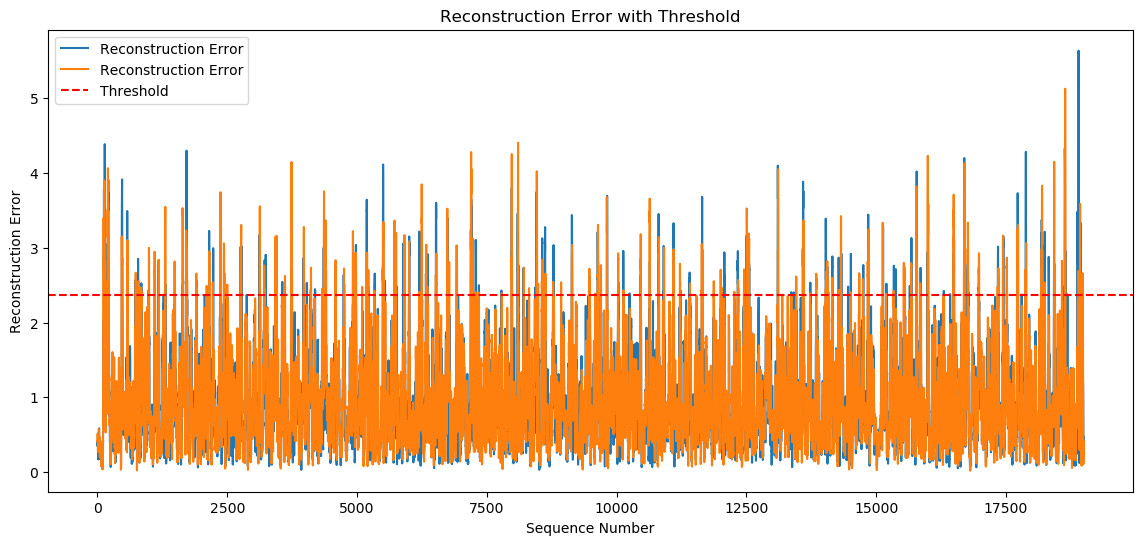

In [2]:

# reconstruction error
plt.figure(figsize=(14, 6))
plt.plot(reconstruction_error, label='Reconstruction Error')
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error with Threshold')
plt.xlabel('Sequence Number')
plt.ylabel('Reconstruction Error')
plt.legend()
# plt.savefig('1-Reconstruction Error with Threshold.png')
# plt.close()
plt.show()



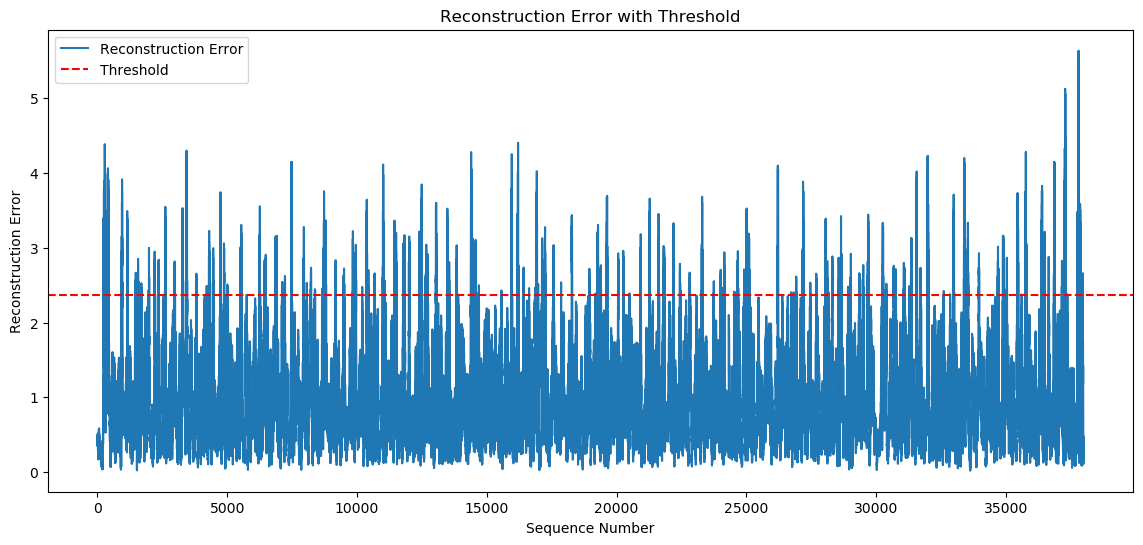

In [3]:
# Flatten the reconstruction_error to 1D
reconstruction_error_flat = reconstruction_error.flatten()
# reconstruction error
plt.figure(figsize=(14, 6))
plt.plot(reconstruction_error_flat, label='Reconstruction Error')
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error with Threshold')
plt.xlabel('Sequence Number')
plt.ylabel('Reconstruction Error')
plt.legend()
# plt.savefig('1-Reconstruction Error with Threshold.png')
# plt.close()
plt.show()


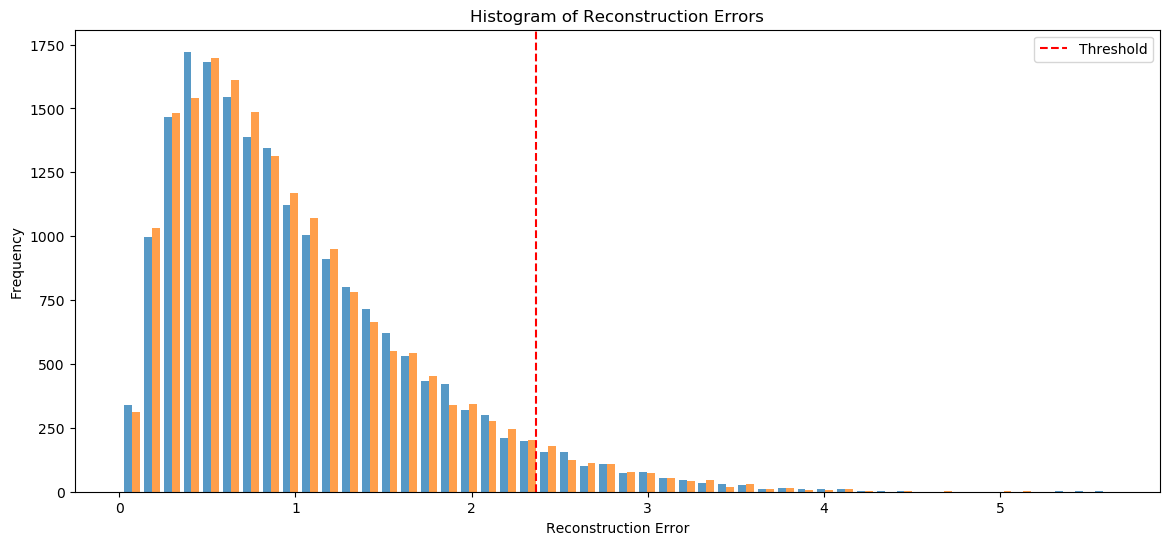

In [4]:
#Histogram of Reconstruction Errors:
plt.figure(figsize=(14, 6))
plt.hist(reconstruction_error, bins=50, alpha=0.75)
plt.axvline(x=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
# plt.savefig('4-Histogram of Reconstruction Errors.png')
# plt.close()
plt.show()


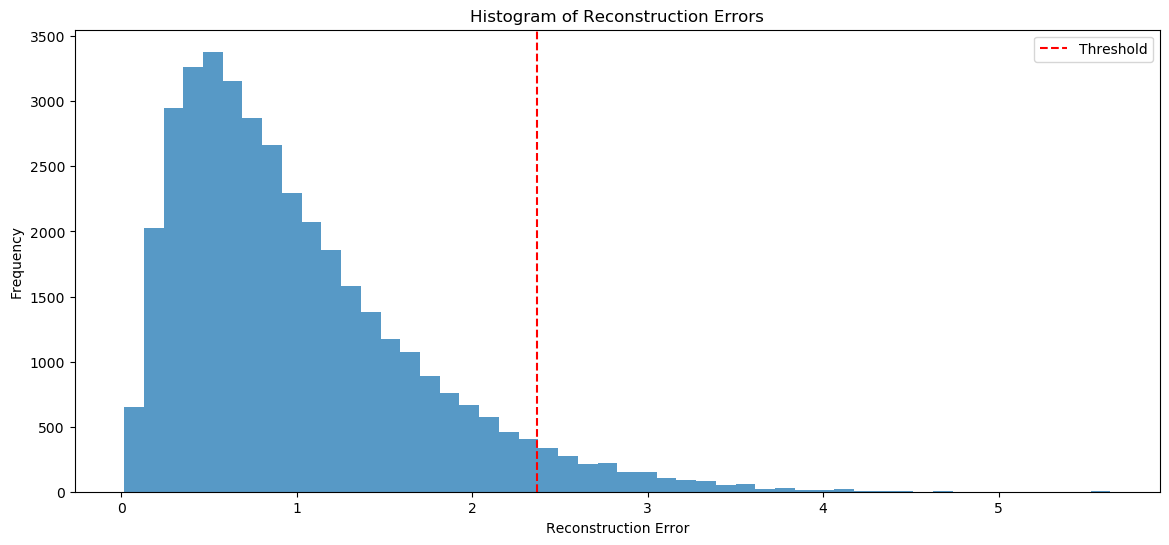

In [5]:
# Flatten the reconstruction_error to 1D
reconstruction_error_flat = reconstruction_error.flatten()
#Histogram of Reconstruction Errors:
plt.figure(figsize=(14, 6))
plt.hist(reconstruction_error_flat, bins=50, alpha=0.75)
plt.axvline(x=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
# plt.savefig('4-Histogram of Reconstruction Errors.png')
# plt.close()
plt.show()

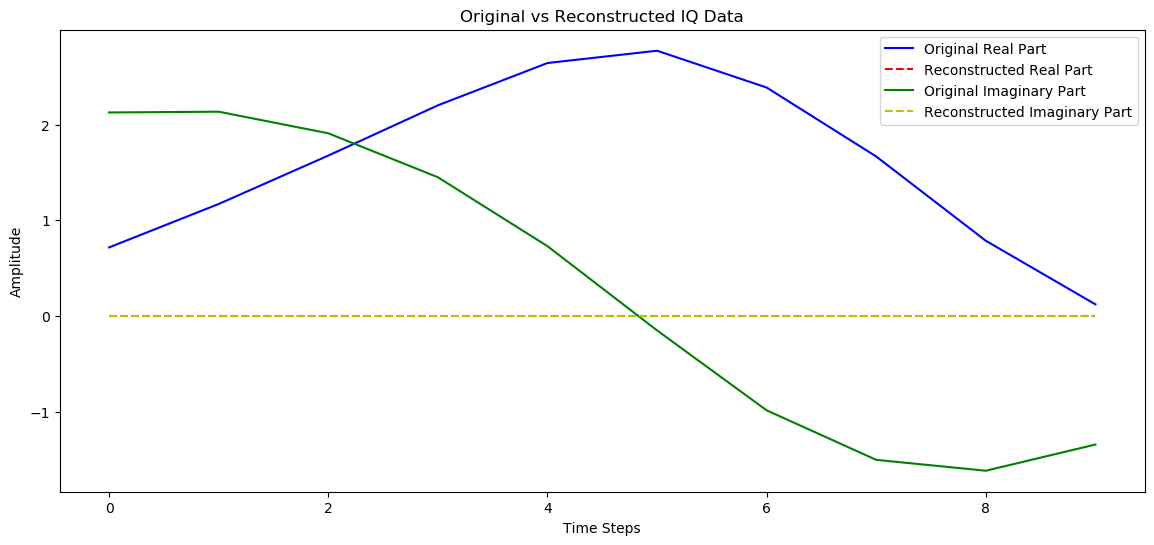

In [6]:
#Time Series Plot of IQ Samples:
sample_index = np.random.choice(len(X_chunk_test))
original_sample = X_chunk_test[sample_index]
reconstructed_sample = X_chunk_pred[sample_index]

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'g-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'y--', label='Reconstructed Imaginary Part')
plt.title('Original vs Reconstructed IQ Data')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('5-Original vs Reconstructed IQ Data.png')
# plt.close()
plt.show()


Shape of avg_real: (190,)
Shape of avg_imag: (190,)
Shape of last_errors: 190


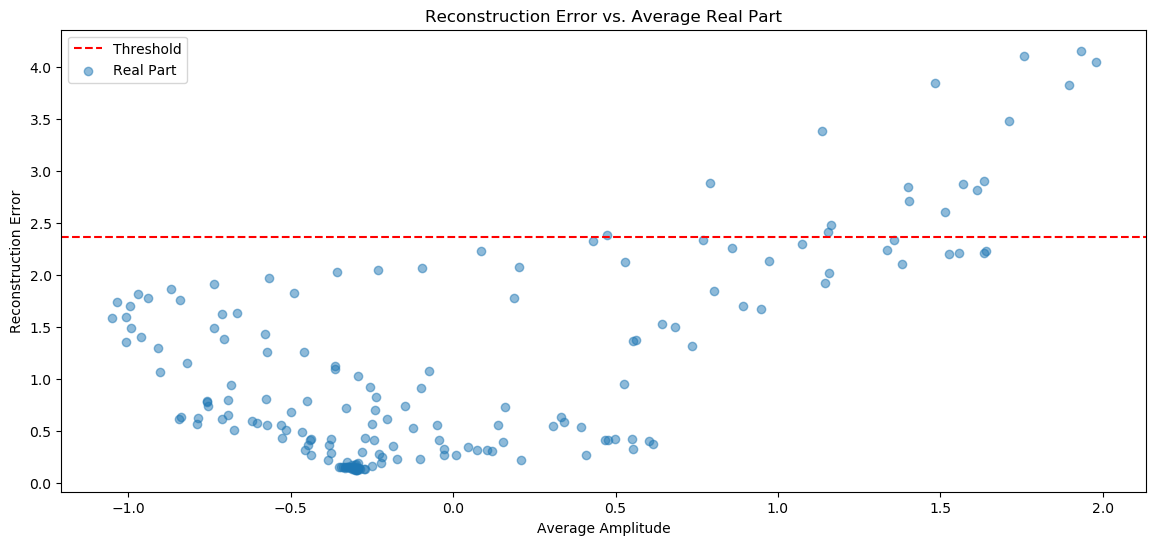

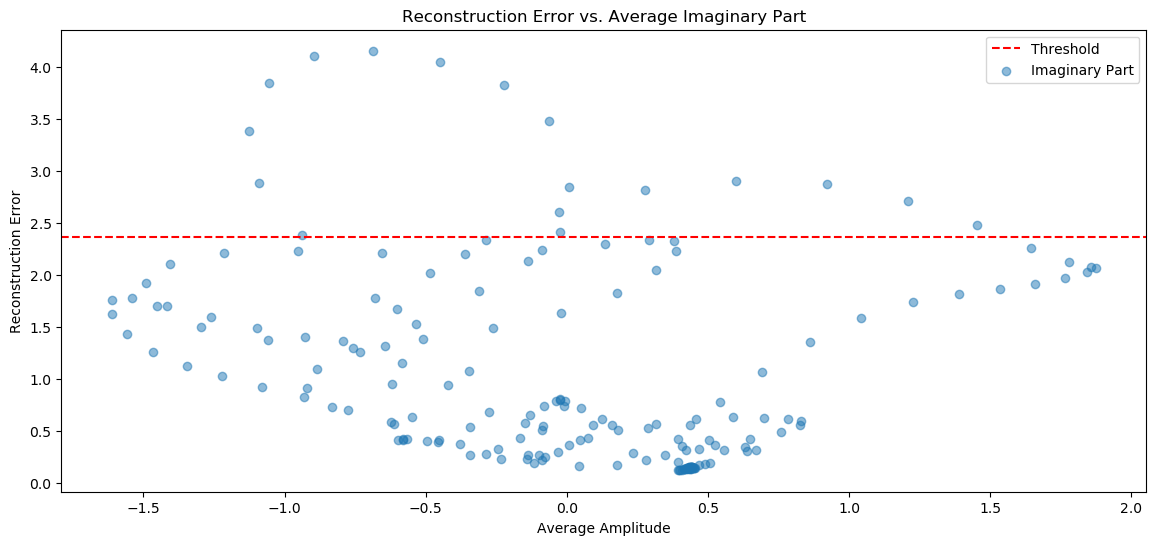

In [7]:
#Scatter Plot of Reconstruction Errors vs. Real and Imaginary Parts:
avg_real = np.mean(X_chunk_test, axis=1)[:, 0]
avg_imag = np.mean(X_chunk_test, axis=1)[:, 1]

last_errors = np.mean(reconstruction_errors[-len(X_chunk_test):], axis=1)

print("Shape of avg_real:", avg_real.shape)
print("Shape of avg_imag:", avg_imag.shape)
print("Shape of last_errors:", len(last_errors))


plt.figure(figsize=(14, 6))
plt.scatter(avg_real, last_errors, label='Real Part', alpha=0.5)
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error vs. Average Real Part')
plt.xlabel('Average Amplitude')
plt.ylabel('Reconstruction Error')
plt.legend()
# plt.savefig('6-Reconstruction Error vs. Average Real Part.png')
# plt.close()
plt.show()

plt.figure(figsize=(14, 6))
plt.scatter(avg_imag, last_errors, label='Imaginary Part', alpha=0.5)
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error vs. Average Imaginary Part')
plt.xlabel('Average Amplitude')
plt.ylabel('Reconstruction Error')
plt.legend()
# plt.savefig('7-Reconstruction Error vs. Average Imaginary Part.png')
# plt.close()
plt.show()

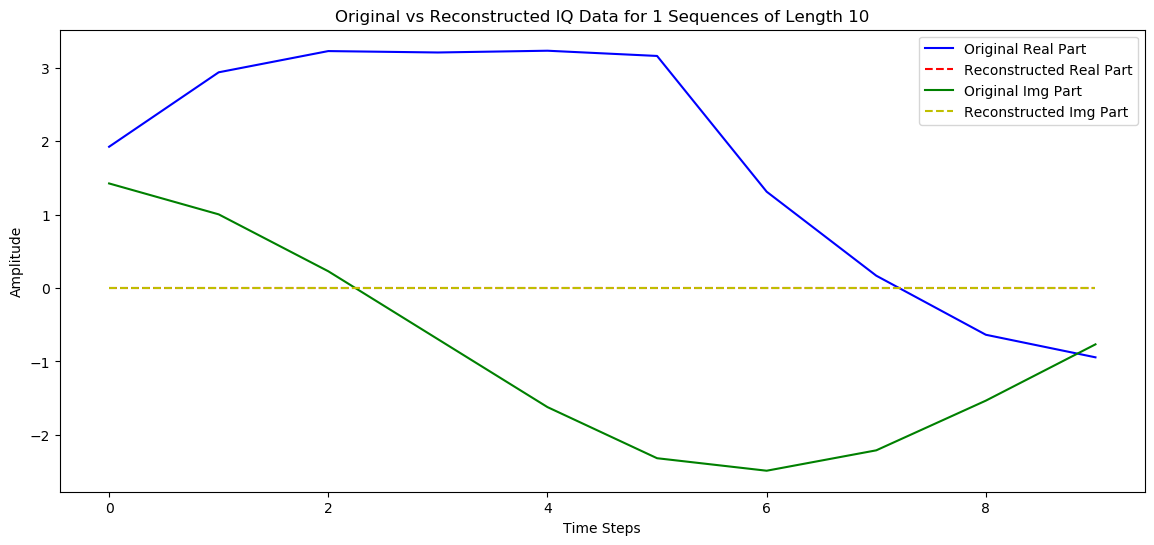

In [8]:
# # Define the number of sequences to plot together
n = 1  # Change this to desired number of sequences
sample_length = sequence_length * n

# Select a random starting sequence for plotting
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)

# Extract and concatenate the original and reconstructed samples
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

# Plot concatenated sequences
plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'g-', label='Original Img Part')
plt.plot(reconstructed_sample[:, 1], 'y--', label='Reconstructed Img Part')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('9-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

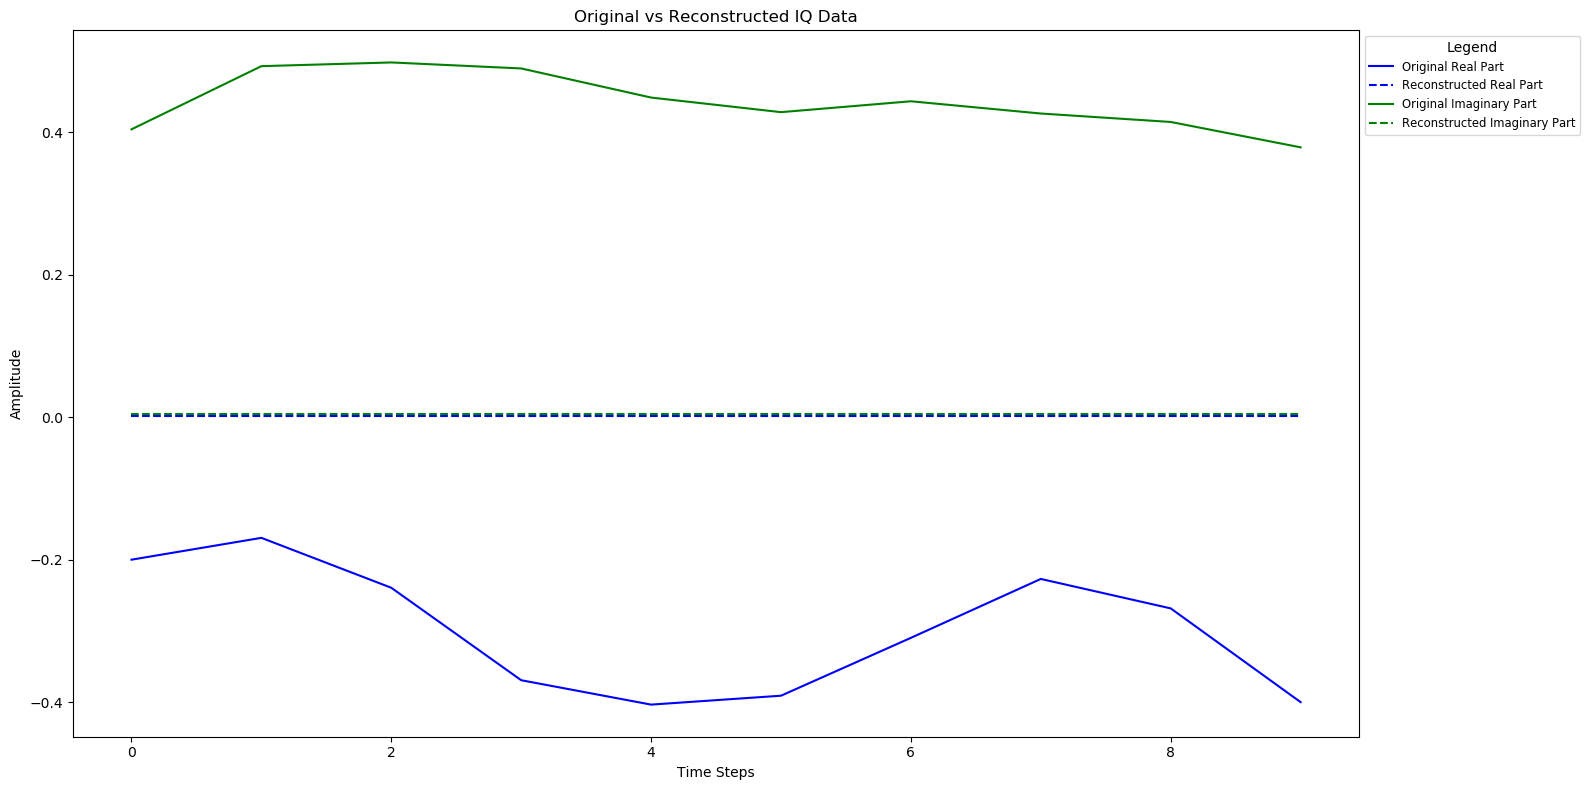

In [9]:
sample_index = np.random.choice(len(X_chunk_test))
original_sample = X_chunk_test[sample_index]
reconstructed_sample = X_chunk_pred[sample_index]

plt.figure(figsize=(16, 8))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'b--', label='Reconstructed Real Part')
# plt.plot(original_sample[:, 1], 'm-', label='Original Real STD')
# plt.plot(reconstructed_sample[:, 1], 'm--', label='Reconstructed Real STD')
# plt.plot(original_sample[:, 2], 'c-', label='Original Real Skew')
# plt.plot(reconstructed_sample[:, 2], 'c--', label='Reconstructed Real Skew')
# plt.plot(original_sample[:, 3], 'orange', label='Original Real Kurtosis')
# plt.plot(reconstructed_sample[:, 3], 'orange', label='Reconstructed Real Kurtosis', linestyle='--')

plt.plot(original_sample[:, 1], 'g-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'g--', label='Reconstructed Imaginary Part')
# plt.plot(original_sample[:, 5], 'purple', label='Original Imaginary STD')
# plt.plot(reconstructed_sample[:, 5], 'purple', label='Reconstructed Imaginary STD', linestyle='--')
# plt.plot(original_sample[:, 6], 'brown', label='Original Imaginary Skew')
# plt.plot(reconstructed_sample[:, 6], 'brown', label='Reconstructed Imaginary Skew', linestyle='--')
# plt.plot(original_sample[:, 7], 'pink', label='Original Imaginary Kurtosis')
# plt.plot(reconstructed_sample[:, 7], 'pink', label='Reconstructed Imaginary Kurtosis', linestyle='--')
plt.title('Original vs Reconstructed IQ Data')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')

# Place the legend outside the plot area
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small', title='Legend')

# Adjust layout to make room for the legend
plt.tight_layout()

plt.show()


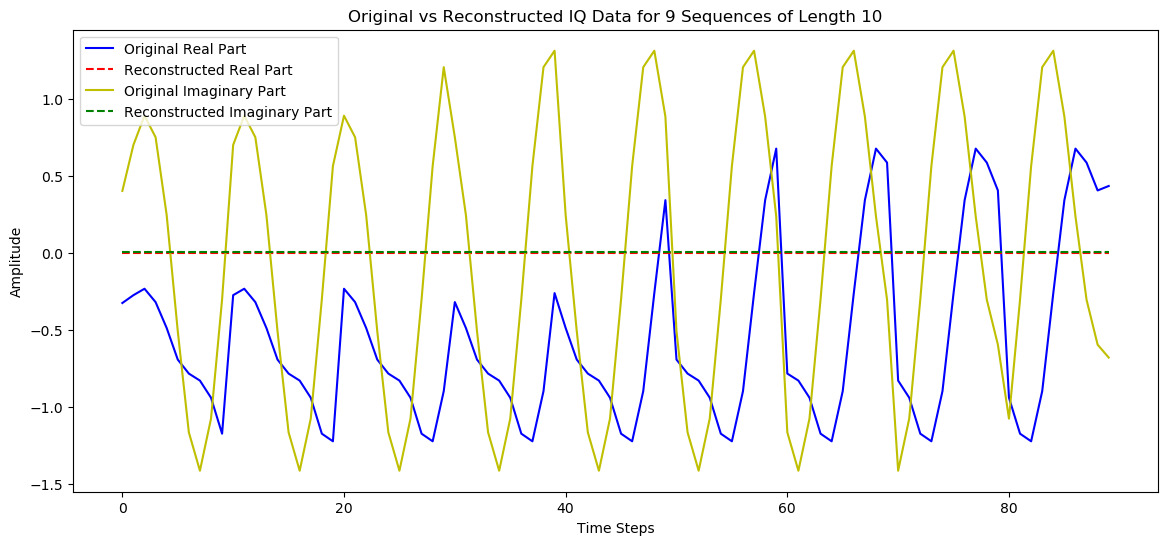

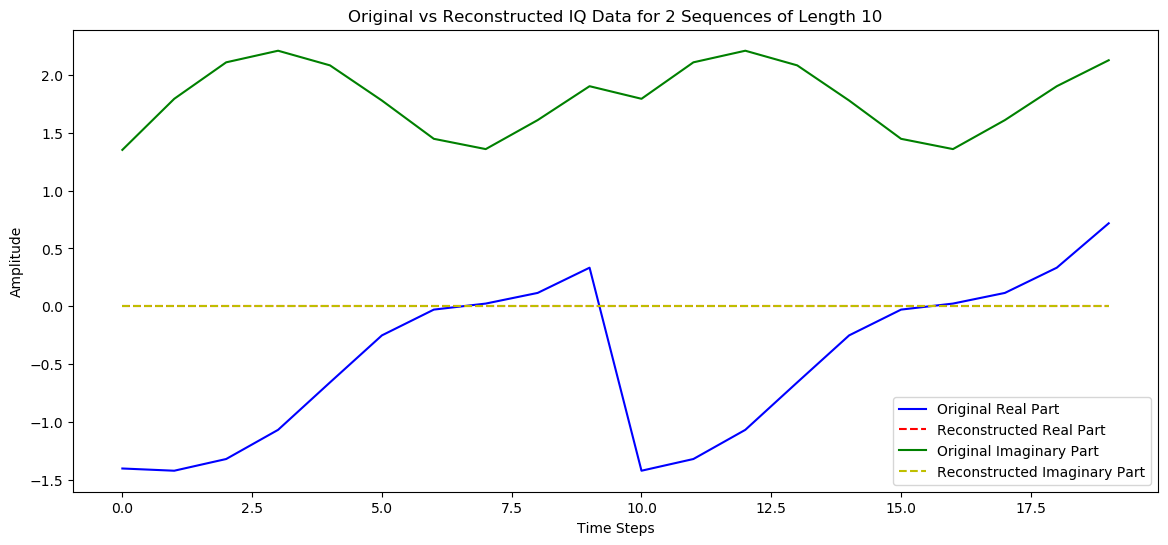

In [28]:
# # Define the number of sequences to plot together
n = 9  # Change this to desired number of sequences
sample_length = sequence_length * n

# Select a random starting sequence for plotting
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)

# Extract and concatenate the original and reconstructed samples
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

# Plot concatenated sequences
plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
# plt.plot(original_sample[:, 1], 'orange', label='Original Real STD')
# plt.plot(reconstructed_sample[:, 1], 'orange', label='Reconstructed Real STD', linestyle='--')

plt.plot(original_sample[:, 1], 'y-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'g--', label='Reconstructed Imaginary Part')
# plt.plot(original_sample[:, 5], 'pink', label='Original Imaginary STD')
# plt.plot(reconstructed_sample[:, 5], 'pink', label='Reconstructed Imaginary STD', linestyle='--')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('9-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

# Repeat for n = 9
n = 2  # Change this to desired number of sequences
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'g-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'y--', label='Reconstructed Imaginary Part')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('11-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

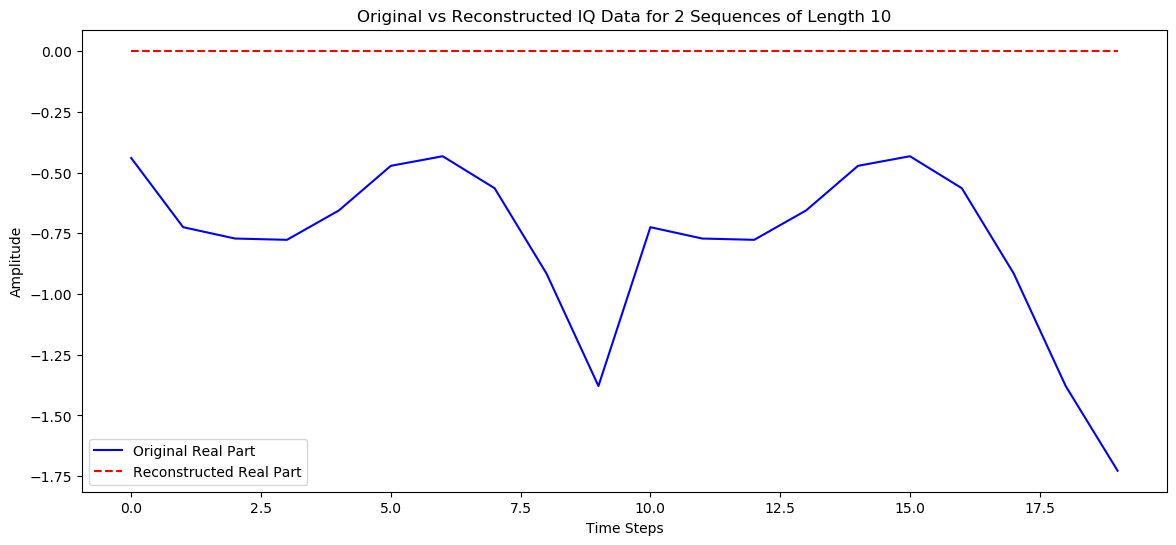

In [11]:
# Repeat for n = 9
n = 2  # Change this to desired number of sequences
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')

plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('11-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

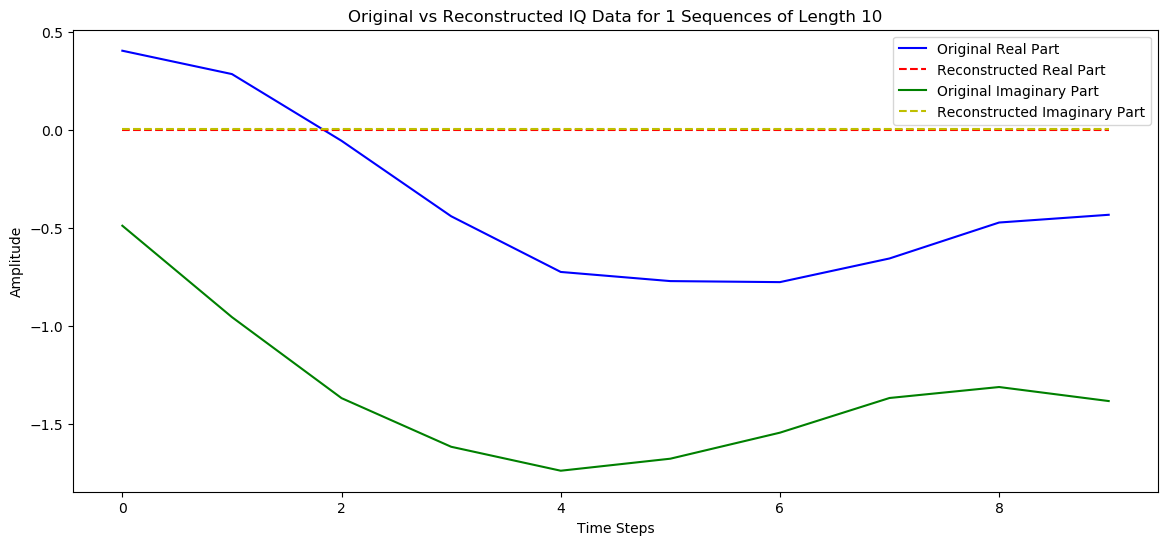

In [12]:
# Repeat for n = 9
n = 1  # Change this to desired number of sequences
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'g-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'y--', label='Reconstructed Imaginary Part')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('11-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

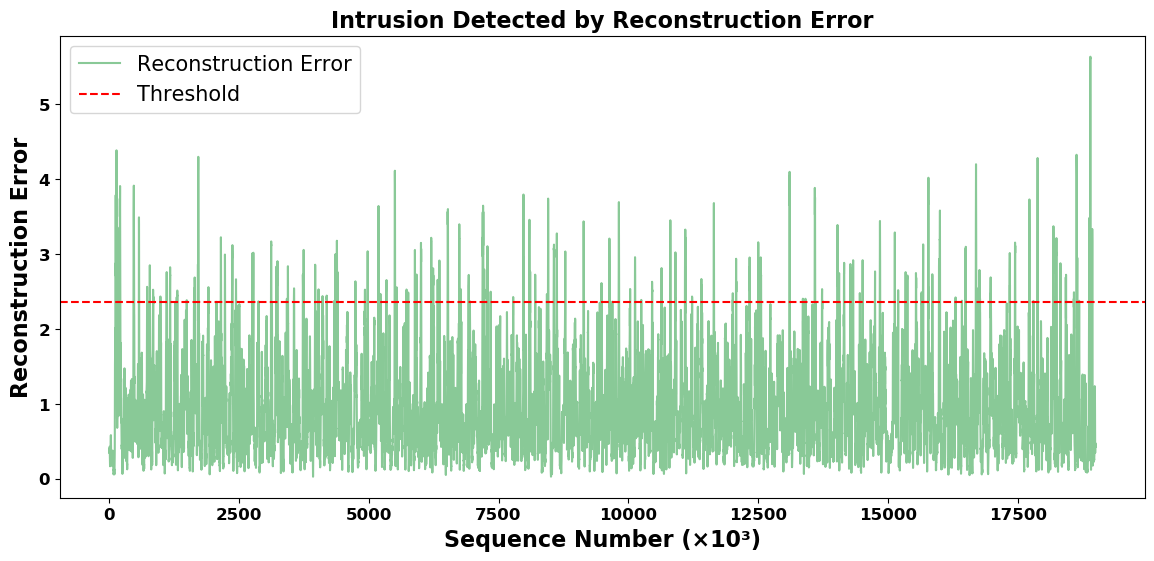

In [13]:
# reconstruction error
reconstruction_error_real = reconstruction_error[:, 0]
reconstruction_error_imag = reconstruction_error[:, 1]

# Plot for Real Part
plt.figure(figsize=(14, 6))
mellow_green = '#89C997' 
plt.plot(reconstruction_error_real, label='Reconstruction Error', color=mellow_green)
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Intrusion Detected by Reconstruction Error',fontsize=16, fontweight='bold')
plt.xlabel('Sequence Number (×10³)', fontsize=16, fontweight='bold')
#plt.xlabel('Sequence Number(*1000)', fontsize=16, fontweight='bold')
plt.ylabel('Reconstruction Error', fontsize=16, fontweight='bold')
for label in (plt.gca().get_xticklabels() + plt.gca().get_yticklabels()):
    label.set_fontsize(12)
    label.set_fontweight('bold')
plt.legend(fontsize=15)
plt.show()